Project #5: Video Stitching and Processing 

https://courses.grainger.illinois.edu/cs445/sp2025/projects/video/ComputationalPhotograph_ProjectVideo.html

## CS445: Computational Photography

### Setup


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# modify to where you store your project data including utils
datadir = "/home/tars/Projects/UIUC-Computational-Photography/Project_5/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

cp: '/home/tars/Projects/UIUC-Computational-Photography/Project_5/utils.py' and './utils.py' are the same file
cp: '/home/tars/Projects/UIUC-Computational-Photography/Project_5/images' and './images' are the same file


In [3]:
# !pip uninstall opencv-python -y
# # downgrade OpenCV a bit to use SIFT
# # !pip install opencv-contrib-python==4.5.5.64 --force-reinstall
!pip install opencv-contrib-python==4.9.0.80
!pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [4]:
def auto_homography(Ia, Ib, homography_func=None, niter=1000):
    '''
    Computes a homography that maps points from Ia to Ib

    Outputs H, the best homography matrix from the iterations

    So, what are we really doing here?

    Well, we will define our homography function later and pass it into this function, but the idea in general is
    to find the homography matrix (matrix that maps points from one place to another) that best maps points from
    image Ia to image Ib. 

    How do we do it?

    (1) computing homography H between frame 450 and each other frame
    (2) projecting each frame onto the same surface
    (3) blend the surfaces
    
    '''

    Ia_gray = cv2.cvtColor(Ia, cv2.COLOR_BGR2GRAY)                    # Convert images to grayscale because SIFT does not use
                                                                      # color, but rather intensity values
    Ib_gray = cv2.cvtColor(Ib, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()                                          # Init the sift detector

    kp_a, des_a = sift.detectAndCompute(Ia_gray, None)                # Find the keypoints and descriptors with SIFT
    kp_b, des_b = sift.detectAndCompute(Ib_gray, None)

    bf = cv2.BFMatcher()                                              # BFMatcher with default parameters. We are just getting
                                                                      # the matches of keypoints between our two images
    matches = bf.knnMatch(des_a, des_b, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:                            # Apply ratio test. We only will take instances where the 
                                                                      # best and second best matches are within a threshold,
                                                                      # and we consider those as "good"
            good.append(m)

    numMatches = len(good)
    
    Xa = np.ones((3, numMatches))                                                                                                     
    Xb = np.ones((3, numMatches))                                     # Xa and Xb are 3xN matrices that contain homogeneous coordinates 
                                                                      # for the N matching points for each image. We need these because
                                                                      # of the transformation we are trying to compute between the 2 images
    
    for idx, match_i in enumerate(good):
        Xa[:, idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:, idx][0:2] = kp_b[match_i.trainIdx].pt

    best_score = 0                                                    # RANSAC:randomly select a small number of points to estimate the homogrpahy
    best_H = None
    best_inliers = None

    for _ in range(niter):
        subset = np.random.choice(numMatches, 4, replace=False)       # Randomly select 4 points for homography estimation
        pts1 = Xa[:, subset]
        pts2 = Xb[:, subset]

        H_t = homography_func(pts1, pts2)                             # Compute homography using the provided function

        Xb_ = np.dot(H_t, Xa)                                         # Project points from first image to second image using the estimated homography
        du = Xb_[0, :] / Xb_[2, :] - Xb[0, :] / Xb[2, :]
        dv = Xb_[1, :] / Xb_[2, :] - Xb[1, :] / Xb[2, :]

        ok_t = np.sqrt(du**2 + dv**2) < 0.67                          # Compute distances and inliers
        score_t = np.sum(ok_t)

        if score_t > best_score:                                      # Update the best homography if this one is better
            best_score = score_t
            best_H = H_t
            best_inliers = ok_t

    print(f'Best score: {best_score:.2f}')

    return best_H, best_inliers

def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver

    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous coordinates.
    Output: H is a 3x3 matrix, such that pts2 ~= H * pts1

    This is just the homography function we are passing into auto_homography()

    It will be called in the loop section of auto_homography(), such that we call
    it for the random points we select, and replace the result if we find a better
    homography
    '''
    N = pts1.shape[1]

    A = np.zeros((2 * N, 9))
    for i in range(N):                                                # For each pair of corresponding points, we get two 
                                                                      # equations 
        A[2 * i, :] = [-pts1[0, i], -pts1[1, i], -1, 0, 0, 0, pts1[0, i] * pts2[0, i], pts1[1, i] * pts2[0, i], pts2[0, i]]
        A[2 * i + 1, :] = [0, 0, 0, -pts1[0, i], -pts1[1, i], -1, pts1[0, i] * pts2[1, i], pts1[1, i] * pts2[1, i], pts2[1, i]]

    _, _, V = svd(A)                                                  # Then we just solve with SVD and extract the homography
    h = V[-1, :]
    H = np.reshape(h, (3, 3))

    return H

Best score: 109.00
[[-4.86570762e-03 -2.35619818e-04  1.00000000e+00]
 [-5.42427026e-05 -4.59419146e-03  7.04739133e-02]
 [-1.85720169e-06  5.87839245e-09 -3.96099458e-03]]


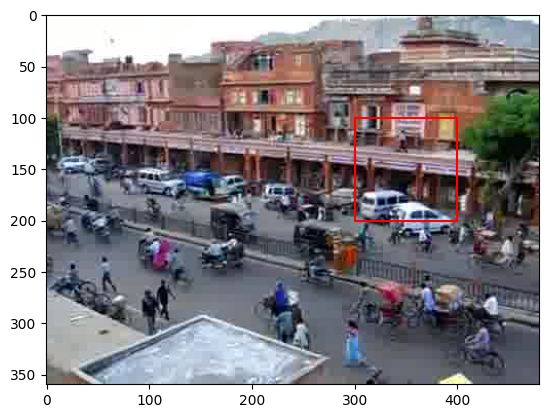

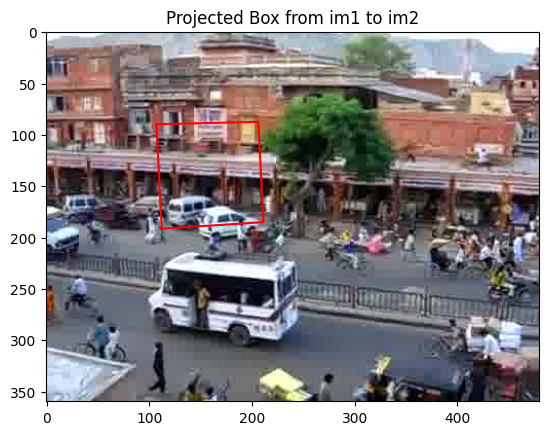

In [5]:
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H, inliers = auto_homography(im1, im2, homography_func=computeHomography, niter=1000)          # Get the homography and inliers using the auto_homography function

print(H/H.max())                                                                               # H = auto_homography(im1,im2, computeHomography)

box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

projected_pts = H @ box_pts                                                                    # Project box_pts from im1 to im2 using the homography H

projected_pts /= projected_pts[2, :]                                                           # Normalize homogeneous coordinates

plt.figure()                                                                                   # Plot the projected box on im2
plt.imshow(im2[:, :, [2, 1, 0]])                                                               # Convert BGR to RGB
plt.plot(projected_pts[0, :], projected_pts[1, :], 'r-')
plt.title('Projected Box from im1 to im2')
plt.show()

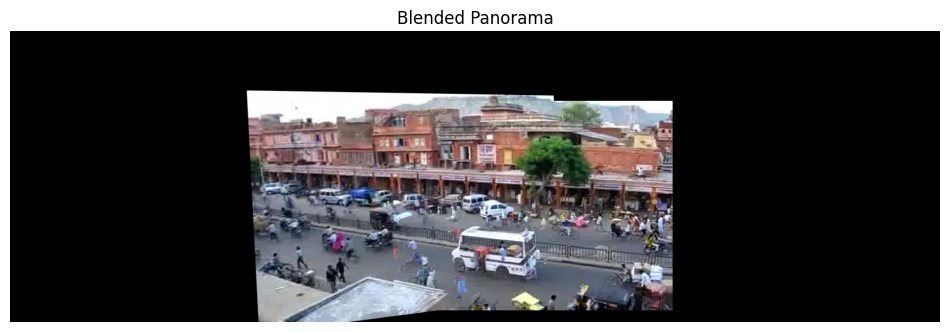

In [6]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float64)             # Make sure Tr is float64.. translation matrix

H_warp = Tr @ H.astype(np.float64)                                                 # Compose the warp homography.. combines the two transformations

im1_warped = cv2.warpPerspective(im1, H_warp, (projectedWidth, projectedHeight))   # Warp images
im2_warped = cv2.warpPerspective(im2, Tr, (projectedWidth, projectedHeight))

blended = np.maximum(im1_warped, im2_warped)                                       # Blend using per pixel max

plt.figure(figsize=(12, 6))
plt.imshow(blended[:, :, [2, 1, 0]])
plt.title("Blended Panorama")
plt.axis('off')
plt.show()

### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


Best score: 49.00
Best score: 115.00
Best score: 89.00
Best score: 37.00


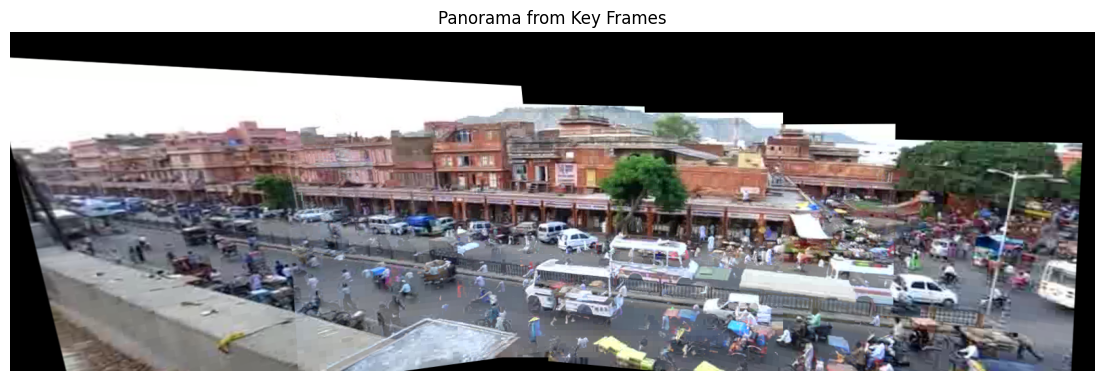

In [7]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1
ref_idx = 2  # index of frame 450 in key_frames_idx

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution

projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float64)

homographies = []                                                     # Homography chain: we store the homography from each frame to the reference (450)

for i, frame in enumerate(frames):
    if i == ref_idx:
        homographies.append(np.eye(3))                                # Identity for the reference frame
    else:
                                                                      # Compute homography from frame i to reference frame
        H, _ = auto_homography(frames[i], frames[ref_idx], homography_func=computeHomography, niter=1000)
        H = H.astype(np.float64)
        homographies.append(H)

canvas = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint8)

for i, (frame, H) in enumerate(zip(frames, homographies)):
    H_warp = Tr @ H
    warped = cv2.warpPerspective(frame, H_warp, (projectedWidth, projectedHeight))
    
    canvas = np.maximum(canvas, warped)                               # Simple max blending

plt.figure(figsize=(14, 6))
plt.imshow(canvas[:, :, [2, 1, 0]])
plt.title("Panorama from Key Frames")
plt.axis("off")
plt.show()

### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [8]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.imread(file_i)

In [10]:
# TO DO part 3 solution

# create your video (see tips)

"""
In this part you will produce a video sequence by projecting all frames onto the plane corresponding to the reference 
frame 450. For those frames that have small or no overlap with the reference frame you need to first map them onto the 
closest key frame. You can produce a direct homography between each frame and the reference frame by multiplying the 
two projection matrices.
"""

key_frames_idx = np.array([90, 270, 450, 630, 810]) - 1                           # Convert to 0-based indexing
ref_idx = np.where(key_frames_idx == 449)[0][0]                                   # Index of frame 450 in key_frames_idx
ref_frame = frames[key_frames_idx[ref_idx]]

key_homographies = {}                                                             # Compute homographies for key frames first
for i, idx in enumerate(key_frames_idx):
    if i == ref_idx:
        key_homographies[idx] = np.eye(3, dtype=np.float64)                       # Identity for reference frame
    else:
        H, _ = auto_homography(frames[idx], ref_frame, homography_func=computeHomography, niter=1000)
        key_homographies[idx] = H.astype(np.float64)

                                                                                  # For all frames, compute homography to reference
final_homographies = []
for i in range(frameCount):
    if i in key_frames_idx:
                                                                                  # Directly use precomputed key frame homography
        final_homographies.append(key_homographies[i])
    else:
                                                                                  # Find nearest key frame
        nearest_key_idx = key_frames_idx[np.argmin(np.abs(key_frames_idx - i))]
        
                                                                                  # Compute homography from current frame to nearest key frame
        H_current_to_key, _ = auto_homography(frames[i], frames[nearest_key_idx], 
                                            homography_func=computeHomography, niter=1000)
        
                                                                                  # Composite homography: current -> key -> reference
        H_composite = key_homographies[nearest_key_idx] @ H_current_to_key.astype(np.float64)
        final_homographies.append(H_composite)

projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float64)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('../Project_5/output_stabilized.mp4', fourcc, 30.0, (projectedWidth, projectedHeight))

for i in range(frameCount):
    H_warp = Tr @ final_homographies[i]                                           # Apply homography and translation
    warped = cv2.warpPerspective(frames[i], H_warp, (projectedWidth, projectedHeight))
    
    out.write(warped)
    
    if i % 50 == 0:
        print(f"Processing frame {i+1}/{frameCount}")

out.release()
print("Video saved as output_stabilized.mp4")

Best score: 50.00
Best score: 115.00
Best score: 77.00
Best score: 41.00
Best score: 289.00
Best score: 288.00
Best score: 291.00
Best score: 289.00
Best score: 314.00
Best score: 318.00
Best score: 319.00
Best score: 297.00
Best score: 323.00
Best score: 344.00
Best score: 351.00
Best score: 322.00
Best score: 341.00
Best score: 346.00
Best score: 300.00
Best score: 331.00
Best score: 344.00
Best score: 342.00
Best score: 332.00
Best score: 325.00
Best score: 328.00
Best score: 361.00
Best score: 359.00
Best score: 344.00
Best score: 357.00
Best score: 361.00
Best score: 349.00
Best score: 359.00
Best score: 355.00
Best score: 363.00
Best score: 355.00
Best score: 365.00
Best score: 351.00
Best score: 359.00
Best score: 358.00
Best score: 353.00
Best score: 338.00
Best score: 362.00
Best score: 355.00
Best score: 364.00
Best score: 374.00
Best score: 339.00
Best score: 367.00
Best score: 356.00
Best score: 343.00
Best score: 324.00
Best score: 370.00
Best score: 369.00
Best score: 360

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


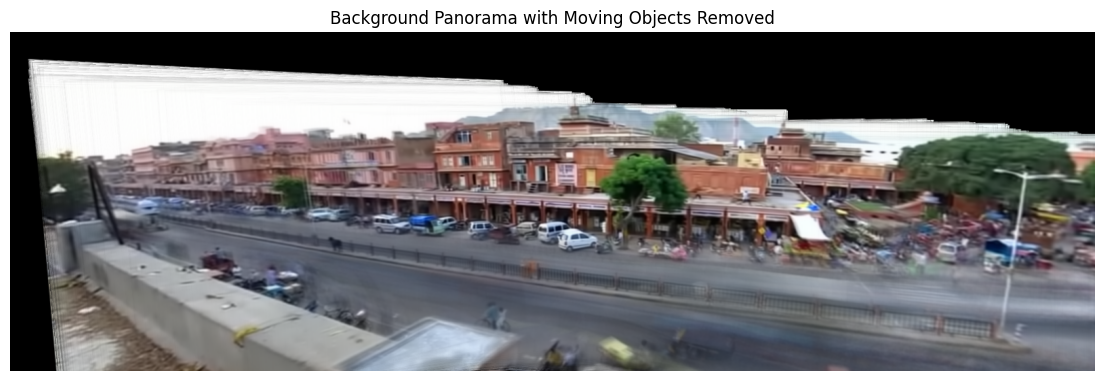

Background panorama saved as background_panorama_median.jpg


In [11]:
"""
What is the idea?

We're stitching a clean background panorama by averaging all warped frames together. Each frame is aligned using homographies, 
and non-black pixels are accumulated. By averaging these over time, moving objects fade away, leaving only the static background. 
The mask helps avoid empty areas where no frames contribute. The result is a seamless panorama without people or cars.
"""

# AVERAGE METHOD - using average pixel color as the calculation method

background_accumulator = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint32)               # Initialize a background accumulator and color count
color_count = np.zeros((projectedHeight, projectedWidth), dtype=np.uint32)

for i in range(frameCount):                                                                            # Process each frame to accumulate colors
    H_warp = Tr @ final_homographies[i]
    warped_frame = cv2.warpPerspective(frames[i], H_warp, (projectedWidth, projectedHeight))
    
    mask = (warped_frame != [0, 0, 0]).any(axis=-1)                                                    # Create a mask for valid pixels (non-black)

    background_accumulator[mask] += warped_frame[mask]                                                 # Accumulate colors where the mask is True
    color_count[mask] += 1

background_panorama = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint8)                   # Create the final background panorama

valid_indices = np.where(color_count > 0)

                                                                                                       # Perform the division only for valid pixels
background_panorama[valid_indices] = (background_accumulator[valid_indices] // color_count[valid_indices][:, np.newaxis])

plt.figure(figsize=(14, 6))
plt.imshow(background_panorama[:, :, [2, 1, 0]])                                                       # Convert BGR to RGB for display
plt.title("Background Panorama with Moving Objects Removed")
plt.axis("off")
plt.show()

cv2.imwrite('../Project_5/background_panorama_average.jpg', background_panorama)
print("Background panorama saved as background_panorama_average.jpg")

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [13]:
"""
What are we trying to do here?

We’re creating a background-only version of the original video by warping the stitched panorama back into each frame’s perspective
using the precomputed homographies. Essentially, we reverse the panorama process—instead of projecting frames onto the panorama, 
we project the panorama onto each frame’s view. 

The result is a video where only the static background remains, with moving objects removed. The transformation matrix Tr helps align
everything properly. The final output is a reconstruction of the original scene
"""

background_panorama = cv2.imread('../Project_5/background_panorama_average.jpg')                               # Load the background panorama created in Part 4

projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float64)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')                                                                       # Create video writer for the output movie
out = cv2.VideoWriter('../Project_5/background_movie.mp4', fourcc, 30.0, (projectedWidth, projectedHeight))

for i in range(frameCount):                                                                                    # Process each frame to create the background movie
    H_warp = Tr @ final_homographies[i]                                                                        # Get the homography for the current frame
    
    warped_background = cv2.warpPerspective(background_panorama, H_warp, (projectedWidth, projectedHeight))    # Warp the background panorama to the current frame
    
    out.write(warped_background)                                                                               # Write the warped frame to the video
    
    if i % 50 == 0:
        print(f"Processing frame {i+1}/{frameCount}")

out.release()
print("Background movie saved as background_movie.mp4")

Processing frame 1/900
Processing frame 51/900
Processing frame 101/900
Processing frame 151/900
Processing frame 201/900
Processing frame 251/900
Processing frame 301/900
Processing frame 351/900
Processing frame 401/900
Processing frame 451/900
Processing frame 501/900
Processing frame 551/900
Processing frame 601/900
Processing frame 651/900
Processing frame 701/900
Processing frame 751/900
Processing frame 801/900
Processing frame 851/900
Background movie saved as background_movie.mp4


### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [14]:
"""
Last part: create the foreground movie

We create a foreground movie by comparing each warped frame to the background panorama. The key idea is that pixels differing
significantly (controlled by the threshold) from the background are considered foreground—likely moving objects. 

For each frame, we:

1) Align both the frame and background using homographies
2) Compute absolute differences to highlight deviations
3) Threshold the differences into a binary mask
4) Apply the mask to isolate foreground pixels.     

The result is a video showing only moving elements (like people or cars) against a black background, effectively "subtracting" the static scene
"""

# TO DO part 6

background_panorama = cv2.imread('../Project_5/background_panorama_average.jpg')

projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float64)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_foreground = cv2.VideoWriter('../Project_5/foreground_movie.mp4', fourcc, 30.0, (projectedWidth, projectedHeight))

threshold = 50                                                                                                   # Foreground detection threshold

for i in range(frameCount):                                                                                      # Process each frame to create the foreground movie
    H_warp = Tr @ final_homographies[i]                                                                          # Get the homography for the current frame
    
    warped_background = cv2.warpPerspective(background_panorama, H_warp, (projectedWidth, projectedHeight))      # Warp the background panorama to the current frame
    
    current_frame = cv2.warpPerspective(frames[i], H_warp, (projectedWidth, projectedHeight))                    # Warp the current frame
    
    foreground_mask = cv2.absdiff(current_frame, warped_background)                                              # Calculate the absolute difference between the current 
                                                                                                                 # frame and the warped background
    
    foreground_mask_gray = cv2.cvtColor(foreground_mask, cv2.COLOR_BGR2GRAY)                                     # Convert the mask to grayscale
    
    _, binary_mask = cv2.threshold(foreground_mask_gray, threshold, 255, cv2.THRESH_BINARY)                      # Threshold the grayscale mask to create a binary mask
    
    foreground_image = cv2.bitwise_and(current_frame, current_frame, mask=binary_mask)                           # Create a foreground image using the binary mask

    
    out_foreground.write(foreground_image)
    
    if i % 50 == 0:
        print(f"Processing frame {i+1}/{frameCount}")

out_foreground.release()
print("Foreground movie saved as foreground_movie.mp4")

Processing frame 1/900
Processing frame 51/900
Processing frame 101/900
Processing frame 151/900
Processing frame 201/900
Processing frame 251/900
Processing frame 301/900
Processing frame 351/900
Processing frame 401/900
Processing frame 451/900
Processing frame 501/900
Processing frame 551/900
Processing frame 601/900
Processing frame 651/900
Processing frame 701/900
Processing frame 751/900
Processing frame 801/900
Processing frame 851/900
Foreground movie saved as foreground_movie.mp4


## Bells and whistles